# Intro

This notebook presents a few methods for solving __classification problems__.

A _classification problem_ is a problem where one wants to model a function whose image (or outputs, or _labels_) lies in a finite discrete set.  For simplicity, in our example, we will assume that this set of labels has only two elements (0 and 1).  This particular case is known as _binary classification problem_.

The structure of this notebook if the following.  We begin by generating the dataset that will be used in the classification problem.  Then, we proceed to train and evaluate a few classification models (_classifiers_), namely, a _support vector machine_, a _logistic regression_, and a _decision tree_. We also use _ray tune_ to tune the hyperparameters of the decision tree classifier.  Lastly, in the appendix, we list a few other classifiers that could have been used in the second part and a few other tools that could also have been used to balance the dataset in the second part.

# Data

<a name="creating-the-data"></a>
## Creating the data

In [3]:
from random import uniform


# Choose the size of our data set.
s = 1000

# Create the features (domain of the function): a list of pairs of random
# numbers, that is, a random subset of the Cartesian plane (R2).
features = [[uniform(0, 10), uniform(0, 10)] for _ in range(s)]

# To create the labels, we will use the following function.  This function
# determines if a number is greater than 5 or not.  In the first case, it
# returns 1, and in the second case, it returns 0.
def binary_class (z: float) -> int:
    if z > float(5):
        return 1
    else:
        return 0

# The next ingredient in the construction of the labels is an array of random
# numbers, which we can interpret as noise (for instance, in the measurements
# of a hypothetical experiment).
noise = [uniform(-1, 1) for _ in range(s)]

# The labels of our problem (image of our function) will be the result of
# applying the binary_class function to the "noisy average" of the coordinates
# of the feature points.  This "noisy average" is the average of the
# coordinates perturbed by adding the random noise.
labels = [ binary_class((features[i][0] + features[i][1])/2 + noise[i])
           for i in range(s) ]


<a name="plotting-the-data"></a>
## Plotting the data

To visualize the data that was created above, we will plot the points of the `feature` list in a squared box, with the points that are labeled 0 painted in red, and the ones labeled 1 painted in blue.

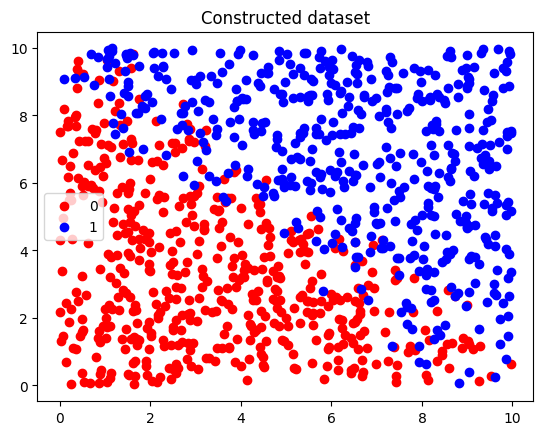

In [4]:
import matplotlib.pyplot as plt


# Collect the items in the 'feature' list that are labeled 0 and 1
# (respectively) in two separate numpy arrays.
zeros = [features[i] for i in range(s) if labels[i] == 0]
ones = [features[i] for i in range(s) if labels[i] == 1]

# To plot, we create lists with the coordinates of the items (pairs) in the
# lists 'zeros' and 'ones'.
zeros_x = [x for (x,y) in zeros]
zeros_y = [y for (x,y) in zeros]
ones_x = [x for (x,y) in ones]
ones_y = [y for (x,y) in ones]

# Plot the items (points in R2) of the 'zeros' list in red and the items of
# the 'ones' list in blue.
plt.scatter(zeros_x, zeros_y, color='red', label='0')
plt.scatter(ones_x, ones_y, color='blue', label='1')

# Show the graph.
plt.title("Constructed dataset")
plt.legend()
plt.show()


# Training and evaluating classification models


To train a _classification model_ (or a _classifier_) is, effectively, to construct a function whose domain contains the points in the `feature` list and whose images on these points approximate their respective labels.  In our particular example, this translates into finding a function that is similar to:
<a name="definition-naive-classifier"></a>
$$
    f : \mathbb{R}^2 \to \{ 0, 1 \},
    \qquad \text{given by} \qquad
    f(x, y) =
    \begin{cases}
        1, & \text{if } \ \frac{x + y}{2} > 5, \\
        0, & \text{if } \ \frac{x + y}{2} \le 5,
    \end{cases}
$$
(compare with <a href="#creating-the-data">`binary_class`</a>).  Due to the `noise` in our data, the value predicted by the trained model will not always agree with the corresponding entry of the `labels` list.  This is the reason why we evaluate the performance of the trained model, that is, estimate the amount of times that the model (dis)agrees with the data.

The process of training a classifier and evaluating its performance is the same for every classifier we choose.  But before we begin this process, we split the dataset into _training_ and _test_ subsets.  The _training subset_ will be used in the training phase, and the _test subset_ will be used in the evaluation phase.

In [5]:
from sklearn.model_selection import train_test_split


# Split the data in two parts: training and test.  The 'train' part will be
# used to train the model; and the 'test' part will be used to evaluate the
# model.
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.33, random_state=1)


Now, we proceed to train (_fit_) the classifier using only the training data.  Then, we evaluate the trained model by comparing the predictions of the trained model on the `features` of test subset to the `labels` of the test subset.  In the cases where the performance of the trained model is good, we stop.  In the other cases, we try to choose parameters of the model that improve its performance.  (This last step is called the _tunning of the hyperparameters_.)  The whole process should become more clear in the examples below.

## Support vector machines

As the first example, we will train and evaluate the performance of a classifier called _Support Vector Machine_ (or SVC).  This is not the only model that can be used for classification problems (see the <a href="#list-of-models-for-classification-problems">list of models for classification problems</a> below), but it provides a good concrete example.  The documentation for this classifier can be obtained from the [scikit-learn webpage](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report


# Train ('fit') the model.
fitted_svc = SVC().fit(x_train, y_train)

# Evaluate the performance of the model by comparing the predictions that
# it makes on the test data (x_test) with the actual data (y_test).
predictions = fitted_svc.predict(x_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       176
           1       0.93      0.93      0.93       154

    accuracy                           0.94       330
   macro avg       0.94      0.94      0.94       330
weighted avg       0.94      0.94      0.94       330



Notice that the performance of this model seems to be good.  To assess how good the classification above actually is and how much it can be improved, we will compare it to the result that one obtains when ignoring the noise and classifying a feature point $(x, y)$ depending solely on whether it is above (${\color{blue}1}$) or below (${\color{red}0}$) the line $\frac{x + y}{2} = 5$ (see the <a href="#definition-naive-classifier">definition of the function $f$</a>).  We will call this reference the _naive classifier_.

In [5]:
# Reference goal for the trained model (naive classifier).

y_reference = [binary_class((x + y)/2) for (x, y) in x_test]
print(classification_report(y_test, y_reference))


              precision    recall  f1-score   support

           0       0.94      0.93      0.93       176
           1       0.92      0.93      0.93       154

    accuracy                           0.93       330
   macro avg       0.93      0.93      0.93       330
weighted avg       0.93      0.93      0.93       330



Notice how similar the result of the SVC classifier is to the naive classifier.  To illustrate this similarity, we will plot the features that are incorrectly classified by the SVC model and by the naive classifier.

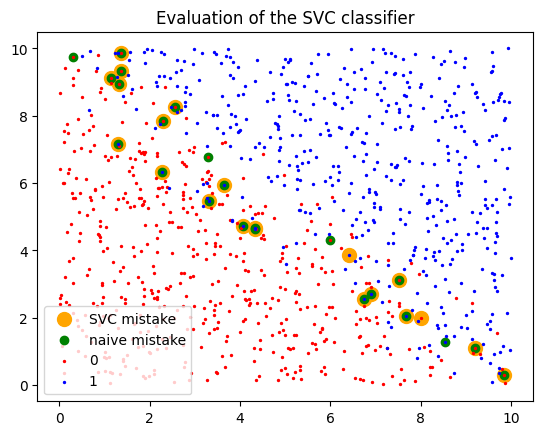

In [11]:
svc_wrong = [x_test[i] for i in range(len(x_test)) if y_test[i] != predictions[i]]
svc_wrong_x = [x for (x, y) in svc_wrong]
svc_wrong_y = [y for (x, y) in svc_wrong]

ref_wrong = [x_test[i] for i in range(len(x_test)) if y_test[i] != y_reference[i]]
ref_wrong_x = [x for (x, y) in ref_wrong]
ref_wrong_y = [y for (x, y) in ref_wrong]

plt.scatter(svc_wrong_x, svc_wrong_y, color='orange', s=100, label="SVC mistake")
plt.scatter(ref_wrong_x, ref_wrong_y, color='green', label="naive mistake")
plt.scatter(zeros_x, zeros_y, color='red', s=2, label="0")
plt.scatter(ones_x, ones_y, color='blue', s=2, label="1")

plt.title("Evaluation of the SVC classifier")
plt.legend()
plt.show()


In fact, we can see in the graph above that the SVC performs really well.  Eventhough it misclassifies several feature points, in most cases it agrees with the naive classifier.

## Logistic regression

In the next example, we will train and evaluate the performance of a classifier called _Logistic Regression_.  The documentation for this classifier can also be obtained from the [scikit-learn webpage](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [12]:
from sklearn.linear_model import LogisticRegression


# Train ('fit') the model.
fitted_lr = LogisticRegression().fit(x_train, y_train)

# Evaluate the performance of the model by comparing the predictions that
# it makes on the test data (x_test) with the actual data (y_test).
predictions = fitted_lr.predict(x_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       176
           1       0.93      0.93      0.93       154

    accuracy                           0.93       330
   macro avg       0.93      0.93      0.93       330
weighted avg       0.93      0.93      0.93       330



Notice that the performance of this model seems to be really good.  To show how good the classification above actually is, we will plot the features that are incorrectly classified by the logistic regression model and by the naive classifier, that is, the classifier one obtains when ignoring the noise and classifying a feature point $(x, y)$ depending solely on whether it is above (${\color{blue}1}$) or below (${\color{red}0}$) the line $\frac{x + y}{2} = 5$.

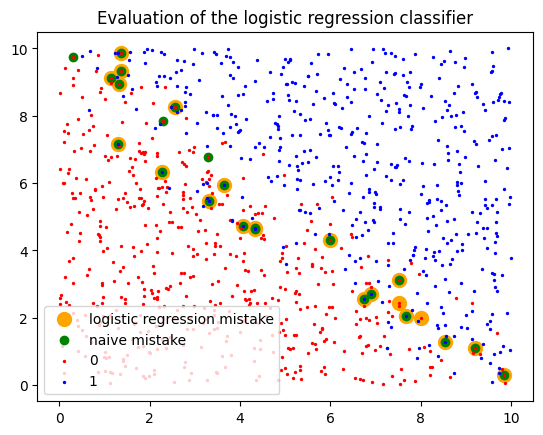

In [13]:
lr_wrong = [x_test[i] for i in range(len(x_test)) if y_test[i] != predictions[i]]
lr_wrong_x = [x for (x, y) in lr_wrong]
lr_wrong_y = [y for (x, y) in lr_wrong]

plt.scatter(lr_wrong_x, lr_wrong_y, color='orange', s=100, label="logistic regression mistake")
plt.scatter(ref_wrong_x, ref_wrong_y, color='green', label="naive mistake")
plt.scatter(zeros_x, zeros_y, color='red', s=2, label="0")
plt.scatter(ones_x, ones_y, color='blue', s=2, label="1")

plt.title("Evaluation of the logistic regression classifier")
plt.legend()
plt.show()


In fact, we can see in the graph above that the logistic regression performs even better than the support vector machines classifier.

## Decision tree

In the last example, we will train and evaluate the performance of a classifier called _decision tree_.  The documentation for this classifier can also be obtained from the [scikit-learn webpage](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


# Train ('fit') the model.
fitted_dt = DecisionTreeClassifier().fit(x_train, y_train)

# Evaluate the performance of the model by comparing the predictions that
# it makes on the test data (x_test) with the actual data (y_test).
predictions = fitted_dt.predict(x_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.85      0.90      0.88       164
           1       0.90      0.84      0.87       166

    accuracy                           0.87       330
   macro avg       0.87      0.87      0.87       330
weighted avg       0.87      0.87      0.87       330



To assess how good the classification above is and how much it can be improved, we will we will plot the features that are incorrectly classified by the decision tree model and by the naive classifier.

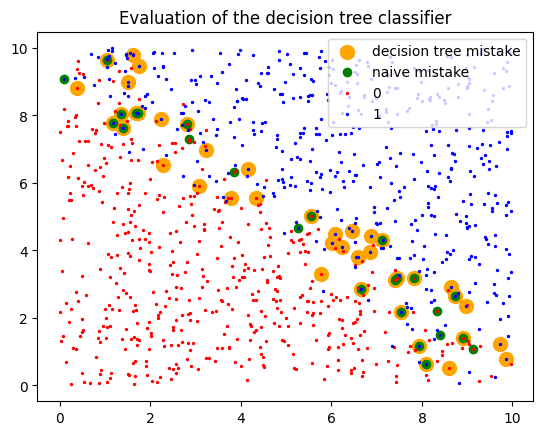

In [7]:
y_reference = [binary_class((x + y)/2) for (x, y) in x_test]
ref_wrong = [x_test[i] for i in range(len(x_test)) if y_test[i] != y_reference[i]]
ref_wrong_x = [x for (x, y) in ref_wrong]
ref_wrong_y = [y for (x, y) in ref_wrong]

dt_wrong = [x_test[i] for i in range(len(x_test)) if y_test[i] != predictions[i]]
dt_wrong_x = [x for (x, y) in dt_wrong]
dt_wrong_y = [y for (x, y) in dt_wrong]

plt.scatter(dt_wrong_x, dt_wrong_y, color='orange', s=100, label="decision tree mistake")
plt.scatter(ref_wrong_x, ref_wrong_y, color='green', label="naive mistake")
plt.scatter(zeros_x, zeros_y, color='red', s=2, label="0")
plt.scatter(ones_x, ones_y, color='blue', s=2, label="1")

plt.title("Evaluation of the decision tree classifier")
plt.legend()
plt.show()


Notice that the trained decision tree model mistakenly classifies several data points that the naive classifier correctly classifies.  To try and improve this performance, in the next section, we will tune the hyperparameters of the decision tree model.

### Tuning the hyperparameters

We begin by doing a random search through a wide range of parameters, using _ray tune_.


In [8]:
!pip install scikit-optimize --quiet
!pip install "ray[tune]" tune-sklearn --quiet


In [ ]:
# First part: a wide and random search
from ray.tune.sklearn import TuneSearchCV
from ray import tune


for _ in range(3):
    parameters = {'criterion': tune.choice(["gini", "entropy", "log_loss"]),
                  'max_depth': tune.randint(1, 100),
                  'min_samples_split': tune.randint(2, 100),
                  'min_samples_leaf': tune.randint(2, 100),
                  'max_leaf_nodes': tune.randint(2, 100),
                  'ccp_alpha': tune.uniform(0, 100)
    }

    tune_search = TuneSearchCV(DecisionTreeClassifier(), parameters, n_trials=3)
    tune_search.fit(x_train, y_train)
    print(tune_search.best_params_)

#{'criterion': 'log_loss', 'max_depth': 38, 'min_samples_split': 27, 'min_samples_leaf': 3, 'max_leaf_nodes': 48, 'ccp_alpha': 75.88192244921112}
#{'criterion': 'log_loss', 'max_depth': 59, 'min_samples_split': 3, 'min_samples_leaf': 45, 'max_leaf_nodes': 22, 'ccp_alpha': 3.2308045354461745}
#{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 72, 'min_samples_leaf': 71, 'max_leaf_nodes': 57, 'ccp_alpha': 10.148206455629971}


Next, we do a finer and exhaustive search through a smaller set of parameters.

In [ ]:
# Second part: a more refined, exhaustive and wide search
from ray.tune.sklearn import TuneGridSearchCV


parameters = {'criterion': ["gini", "log_loss"],
            'max_depth': range(9, 60, 10),
            'min_samples_split': range(3, 80, 10),
            'min_samples_leaf': range(2, 80, 10),
            'max_leaf_nodes': range(2, 60, 10),
            'ccp_alpha': range(0, 80, 10)
}

tune_search = tune.sklearn.TuneGridSearchCV(DecisionTreeClassifier(), parameters)
tune_search.fit(x_train, y_train)
print(tune_search.best_params_)

#{'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_leaf_nodes': 10, 'ccp_alpha': 10}


In [ ]:
# Third part: a more refined, exhaustive and localized search
from ray.tune.sklearn import TuneGridSearchCV


parameters = {'max_depth': range(15, 25, 2),
              'min_samples_split': range(10, 20, 2),
              'min_samples_leaf': range(2, 15, 2),
              'max_leaf_nodes': range(5, 15, 2),
              'ccp_alpha': [0, 0.01, 0.1, 10]
}

tune_search = tune.sklearn.TuneGridSearchCV(DecisionTreeClassifier(), parameters)
tune_search.fit(x_train, y_train)
print(tune_search.best_params_)

#{'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_leaf_nodes': 9, 'ccp_alpha': 0}


Lastly, we use the result obtained above to check if it does indeed lead to a better classifier.

In [22]:
# Checking if the hyperparameters found above improve the performance of the
# classifier.

best_dt = DecisionTreeClassifier(max_depth=15, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=9)
fitted_dt = best_dt.fit(x_train, y_train)
predictions = fitted_dt.predict(x_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.89      0.87      0.88       164
           1       0.87      0.89      0.88       166

    accuracy                           0.88       330
   macro avg       0.88      0.88      0.88       330
weighted avg       0.88      0.88      0.88       330



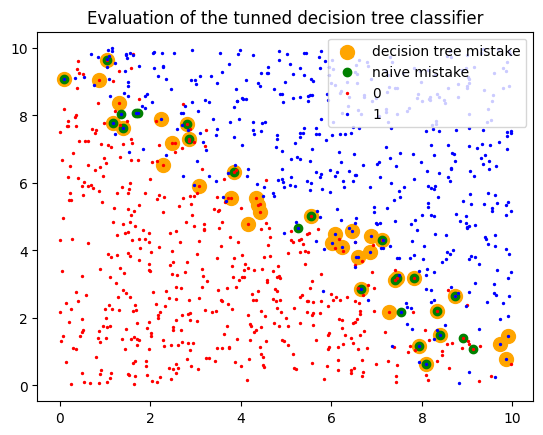

In [23]:
dt_wrong = [x_test[i] for i in range(len(x_test)) if y_test[i] != predictions[i]]
dt_wrong_x = [x for (x, y) in dt_wrong]
dt_wrong_y = [y for (x, y) in dt_wrong]

plt.scatter(dt_wrong_x, dt_wrong_y, color='orange', s=100, label="decision tree mistake")
plt.scatter(ref_wrong_x, ref_wrong_y, color='green', label="naive mistake")
plt.scatter(zeros_x, zeros_y, color='red', s=2, label="0")
plt.scatter(ones_x, ones_y, color='blue', s=2, label="1")

plt.title("Evaluation of the tunned decision tree classifier")
plt.legend()
plt.show()


Notice that, even if the tunned decision tree model performs better than its non-tunned version, unfortunately it does not perform as well as the trained SVC and logistic regression classifiers.

# Appendix

<a name="list-of-models-for-classification-problems"></a>
## List of models for classification problems

Below is a list of the most common models used in classification problems.  Even though this list is not complete, it should help one to get started.  Use the links to learn about and tune the hyperparameters of the classifier.

Random forests: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()


Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [ ]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()


Nearest Neighbors: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()


## List of tools for balancing datasets

When the dataset is heavily unbalanced, that is, when one class of labels has more corresponding features than the others, it is usefull to balance the dataset by removing or creating data points. (One can see this happening, for instance, by replacing 5 by 9 in the <a href="#creating-the-data">definition of the labels</a> above.)

Assess whether a dataset is balanced or not.

In [ ]:
import collections

print(collections.Counter(y_train))


Reduce the dataset by removing data samples randomly.

In [ ]:
# Randomly under-sample
from imblearn.under_sampling import RandomUnderSampler


undersample = RandomUnderSampler(sampling_strategy='majority')
x_under, y_under = undersample.fit_resample(x_train, y_train)


Augment the dataset by creating random data samples.

In [ ]:
# Randomly over-sample
from imblearn.over_sampling import RandomOverSampler


oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(x_train, y_train)


Augment the dataset by creating data samples using [_adaptive syntetic sampling_](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html).

In [ ]:
# Over-sample using ADAptive SYNthetic sampling (ADASYN)
from imblearn.over_sampling import ADASYN


oversample = ADASYN()
x_adasyn, y_adasyn = oversample.fit_resample(x_train, y_train)


Augment the dataset by creating data samples using [_syntetic minority over-sampling technique_](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).

In [ ]:
# Over-sample using Syntetic Minority Over-sampling TEchnique (SMOTE)
from imblearn.over_sampling import SMOTE


oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x_train, y_train)


Augment the dataset by creating data samples using [_borderline SMOTE_](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html).

In [ ]:
# Over-sample using Borderline SMOTE
from imblearn.over_sampling import BorderlineSMOTE


oversample = BorderlineSMOTE()
x_bsmote, y_bsmote = oversample.fit_resample(x_train, y_train)


Augment the dataset by creating data samples using [_SVM SMOTE_](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html).

In [ ]:
# Over-sample using SVM SMOTE
from imblearn.over_sampling import SVMSMOTE


oversample = SVMSMOTE()
x_svmsmote, y_svmsmote = oversample.fit_resample(x_train, y_train)
